In [9]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt

import pyrr
import itertools

# basedir = os.path.dirname(os.getcwd())
basedir = os.path.abspath(os.path.join(os.getcwd() ,"../"))
_py = os.path.join(basedir, 'py')
_data = os.path.join(basedir, 'data')

sys.path.insert(1, _py)
import loads
import lia
import ray as rayt
import lad
import figures

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

# %matplotlib qt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set Up of model

- Set the `mockname` whith the name of the folder where the mock lies.
- Select the downsampling method:
  - `voxel-base`:Set `voxel_size` value.
  - `random-base`: Set `downsample` to not `None` if want to use random-base downsampling.
- Set `Nleaves`.
  
If `downsample` is not `None`, a random downsampling will be implemented. If `None`, the pipeline will use the voxel-based downsampling.
> Note: random-base downsampling is deprecated now but was leave it here in case someone wants to dig in here.

In [10]:
mockname = 'groimp_mock'
# downsampling is always implemented
voxel_size = 0.05

# set to a value to use Random-base downsampling instead of voxel-based downsampling
# 
downsample = None
# downsample = 0.4

# for mocks set the number of triangles per leave in mesh
Nleaves = 2

## Tree and leaves segmentation

Now we create the module to segmentate trees. This will be tuned acordingly for each data set, so below module only works for this particular data set.

In [11]:
def segtree(df, leaves, show=False):

    trees = {}

    if show:
        plt.figure(figsize=(14, 8))

    # centres
    x, y = [-16.6], [-8.16]
    num = 0
    dx, dy = 20, 10
    # dx, dy = 5, 5

    for i in x:
        for j in y:
            
            keep = np.ones(len(df['x']), dtype=bool)
            #keep &= (df['x'] < i+dx) & (df['x'] > i-dx)
            #keep &= (df['y'] < j+dy) & (df['y'] > j-dy)

            trees['tree_%s' %(str(num))] = keep
            
            if show:
                plt.scatter(df['x'][leaves & keep], df['y'][leaves & keep], s=0.5, label=num)
                        
            num += 1

    if show:
        plt.legend()
    
    return trees


We segmentate the trees below,

In [12]:
# Conver `numpy` to `npy`
#loads.numpy2npy(mockname)
loads.csv2npy(mockname)

GroIMP_PointClouds.csv done --> Number of beams: 118018


In [13]:
# load data into a pandas data frame
df = loads.plynpy2pandas(mockname)
N = len(df)

#print(df['z'])
# round x, y, z to match voxel size significative figures
df[['x', 'y', 'z']] = df[['x', 'y', 'z']].round(5)
N = len(df)
print(N)
df[['x', 'y', 'z']].iloc[0]


Number of files: 1
118018


x   -16.124201
y    -7.969200
z     1.847600
Name: 0, dtype: float32

In [14]:

def voxel_subsampling(voxel_size, POINTS):

    nb_vox = np.ceil((np.max(POINTS, axis=0) - np.min(POINTS, axis=0))/voxel_size)
    ni, nj, nk = nb_vox
    print('min point:', np.min(POINTS, axis=0))
    print('max point:', np.max(POINTS, axis=0))
    print('Number of voxels: i:%d, j:%d, k:%d --> Total: %d' %(ni, nj, nk, np.product(nb_vox)))

    non_empty_voxel_keys, inverse, nb_pts_per_voxel = np.unique(((POINTS - np.min(POINTS, axis=0)) // voxel_size).astype(int), axis=0, return_inverse=True, return_counts=True)
    idx_pts_vox_sorted = np.argsort(inverse)
    print('Number of non-empty voxels: %d' %(len(non_empty_voxel_keys)))

    voxel_grid={}
    voxel_grid_ptsidx = {}
    grid_barycenter,grid_candidate_center = [], []
    last_seen=0

    for idx, vox in enumerate(non_empty_voxel_keys):

        idxs_per_vox = idx_pts_vox_sorted[last_seen:last_seen+nb_pts_per_voxel[idx]]
        voxel_grid[tuple(vox)] = POINTS[idxs_per_vox]
        voxel_grid_ptsidx[tuple(vox)] = idxs_per_vox

        # grid_barycenter.append(np.mean(voxel_grid[tuple(vox)],axis=0))

        idx_grid_candidate_center = np.linalg.norm(voxel_grid[tuple(vox)] - np.mean(voxel_grid[tuple(vox)],axis=0),axis=1).argmin()
        grid_candidate_center.append(voxel_grid_ptsidx[tuple(vox)][idx_grid_candidate_center])

        last_seen+=nb_pts_per_voxel[idx]

        # if idx < 5:
        #     print('========')
        #     print(voxel_grid_ptsidx[tuple(vox)][idx_grid_candidate_center])

    # print('Downsampling percentage: %.1f %%' %(100 * len(grid_candidate_center) / len(POINTS)))
    # minpoint = np.min(POINTS, axis=0)

    # return list(grid_candidate_center) #, minpoint
    return list(grid_candidate_center)

# Sanity check
leaves = np.ones(len(df), dtype=bool)
# for i in ['x', 'y']:
#     leaves &= (df[i] > -1) & (df[i] < 1)
# leaves &= (df['z'] > 1)

_POINTS = df[['x', 'y', 'z']][leaves].to_numpy()
vox, inverse, nb_pts_per_voxel = np.unique((np.round(_POINTS - np.min(_POINTS, axis=0), 10) // voxel_size).astype(int), axis=0, return_inverse=True, return_counts=True)

for i in set(vox[:,2]):
    print('K:',i, '-- Non empty voxels -->', np.sum(vox[:,2] == i))

K: 0 -- Non empty voxels --> 25
K: 1 -- Non empty voxels --> 51
K: 2 -- Non empty voxels --> 64
K: 3 -- Non empty voxels --> 191
K: 4 -- Non empty voxels --> 254
K: 5 -- Non empty voxels --> 249
K: 6 -- Non empty voxels --> 216
K: 7 -- Non empty voxels --> 178
K: 8 -- Non empty voxels --> 116
K: 9 -- Non empty voxels --> 70
K: 10 -- Non empty voxels --> 45
K: 11 -- Non empty voxels --> 15
K: 12 -- Non empty voxels --> 9


In [15]:
def random_downsample(N, downsample):

    resdir = os.path.join(_data, mockname, 'random_%s' %(str(downsample)))
    if not os.path.exists(resdir):
        os.makedirs(resdir)

    outdir = os.path.join(resdir, 'inds.npy')
    if os.path.exists(outdir):
        print('inds file already exists for donwnsample of %.3f at %s' %(downsample, outdir))

        idx = np.load(outdir)

    else:

        print('inds not been created yet for donwnsample of %.3f' %(downsample))
        idx = np.random.randint(0, N, int(N * downsample))
        # inds = np.zeros(N, dtype=bool)
        # inds[idx] = True

        np.save(outdir, idx)

    return idx

### Implement and keep Downsampled points

Below code will implement a downsampling using either `random` or `voxel`. The donsampling is performed by saving the corresponding indexes list of the downsampled percentage from the original data size. If index list already exists we just take it to make the downsampling, if it does not exist yet, we created and save ir under its corresponding directory.

In [16]:

if downsample is not None:
    inds = random_downsample(N, downsample)
    print('Random downsampling...')
else:
    inds = voxel_subsampling(voxel_size, df[['x', 'y', 'z']].to_numpy())
    print('Voxel downsampling...')

print('Downsampling percentage: %.1f %%' %(100 *  len(inds) / len(df['x'])))

df = df.iloc[inds]
POINTS = df[['x', 'y', 'z']].to_numpy()
SENSORS = df[['sx', 'sy', 'sz']].to_numpy()

# Compute lower point
minpoint = np.min(POINTS, axis=0) # check this...
print('minpoint:', minpoint)


min point: [-17.557   -8.7296   1.4448]
max point: [-16.0736  -6.681    2.0947]
Number of voxels: i:30, j:41, k:13 --> Total: 15990
Number of non-empty voxels: 1483
Voxel downsampling...
Downsampling percentage: 1.3 %
minpoint: [-17.529   -8.7051   1.4462]


### leave and tree segmentation

In [17]:
# extract leaves. Boolean array output
leaves = np.ones(len(df), dtype=bool)
# for i in ['x', 'y']:
#     leaves &= (df[i] > -1) & (df[i] < 1)
# leaves &= (df['z'] > 1)

# extract trees. Dictionary with boolean arrays output
trees = segtree(df, leaves, show=False)

# Show point cloud of leaves
loads.showPCfromDF(df[['x', 'y', 'z']][leaves])

### Second downsampling: keep only points that colide with Plant Region

In [18]:
inPR = (leaves) & (trees['tree_0'])
minBB, maxBB = np.min(POINTS[inPR], axis=0), np.max(POINTS[inPR], axis=0)

# if minpointPR is None:
minpointPR = minpoint + np.floor(np.abs(minpoint - minBB)/voxel_size) * voxel_size
# if maxpointPR is None:
maxpointPR = minpoint + np.ceil(np.abs(minpoint - maxBB)/voxel_size) * voxel_size

print(minpointPR, maxpointPR)

boxPR = pyrr.aabb.create_from_bounds(minpointPR, maxpointPR)

lines = np.stack((POINTS, SENSORS), axis=1)
f = lambda line: pyrr.geometric_tests.ray_intersect_aabb(pyrr.ray.create_from_line(line), boxPR) is not None
# res = np.array(list(map(f, lines)))
res = []

for num, line in enumerate(lines):

    try:
        res.append(f(line))
    except Exception as e:
        res.append(False)
        print('Error:', e)
        print('On line:',num)

res = np.array(res)

[-17.529   -8.7051   1.4462] [-16.078999  -6.7051     2.0962  ]


In [19]:
POINTS, SENSORS = POINTS[res], SENSORS[res]

leaves = leaves[res]

for key, val in trees.items():
    trees[key] = val[res]

In [20]:
# save indexes of voxel-based downsample

idxs = np.array(inds)[res]

if downsample is not None:
    dirname = 'random_%s' %(str(downsample))
    resdir = os.path.join(_data, mockname, dirname, 'lad_%s' %(str(voxel_size)))
else:
    dirname = 'voxel'
    resdir = os.path.join(_data, mockname, dirname, 'lad_%s' %(str(voxel_size)))

if not os.path.exists(resdir): os.makedirs(resdir)
outdir = os.path.join(resdir, 'inds.npy')
np.save(outdir, idxs)

## Ray tracing

In [21]:
sample = None

inPR = (leaves) & (trees['tree_0'])

if sample is not None:
    print('# iter...', len(POINTS[::sample]))
    m3s = rayt.main2(POINTS[::sample], SENSORS[::sample], POINTS[inPR], voxel_size, resdir, 'tree_0', (minpointPR, maxpointPR), show=True)
else:
    print('# iter...', len(POINTS))
    print('Results will be saved at %s' %(resdir))
    print('-------------')
    m3s = rayt.main2(POINTS, SENSORS, POINTS[inPR], voxel_size, resdir, 'tree_0', (minpointPR, maxpointPR), show=False)

# iter... 1483
Results will be saved at /mnt/sda/Github/LiDAR/data/groimp_mock/voxel/lad_0.05
-------------


1483it [00:17, 85.21it/s] 

tot vox: 	 15080
voxels hitted: 	 3274
Percentage of voxels hitted by beam: 0.22
voxels hitted (OLD): 	 0
Percentage of voxels hitted by beam (OLD): 0.00


## LIA

In [22]:
def best_fit_lia(mockname, Nleaves):

    df = loads.plynpy2pandas(mockname)
    # extract leaves. Boolean array output
    
    # leaves = loads.extract_leaves(df, show=False)
    leaves = np.ones(len(df), dtype=bool)
    # for i in ['x', 'y']:
    #     leaves &= (df[i] > -1) & (df[i] < 1)

    # extract trees. Dictionary with boolean arrays output
    trees = segtree(df, leaves, show=False)

    for key, val in trees.items():

        keep = (val) & (leaves) # take the LPC per tree
        points = df[['x', 'y', 'z']].to_numpy()[keep]

        res = lia.bestfit_pars_la(points, mockname, Nleaves, treename=key)
        lia.best_fit_pars_plot(res, key, mockname)

In [23]:
def get_lia(mockname):

    df = loads.plynpy2pandas(mockname)

    # extract leaves. Boolean array output

    # leaves = loads.extract_leaves(df, show=False)
    leaves = np.ones(len(df), dtype=bool)
    # for i in ['x', 'y']:
    #     leaves &= (df[i] > -1) & (df[i] < 1)

    # extract trees. Dictionary with boolean arrays output
    trees = segtree(df, leaves, show=False)


    # load bestfit results
    for key, val in trees.items():

        keep = (val) & (leaves)
        print(sum(keep), len(keep))
        points = df[['x', 'y', 'z']].to_numpy()[keep]
    
        bestfit_file = os.path.join(_data, mockname, 'lia', 'bestfit_%s.npy' %(key))
        res = np.load(bestfit_file, allow_pickle=True)
        res = res.tolist()

        text = 'leaf area=%.2f \n %s=%.4f \n %s=%.4f \n %s=%.4f ' %(res['leafsize'], 'voxel_size_w', res['voxel_size_w_bestfit'],'kd3_sr', res['kd3_sr_bestfit'],'max_nn', res['max_nn_bestfit'])
        print(text)

        chi2 = lia.leaf_angle(points, mockname, key, res['voxel_size_w_bestfit'], 
                                res['kd3_sr_bestfit'], res['max_nn_bestfit'], save=True,
                                    savefig=True, text=text, voxel_size_h=0.1)

        # save indexes from main df
        # inds = np.where((val) & (leaves))
        np.save(os.path.join(_data, mockname, 'lia', 'inds.npy'), keep)


In [24]:
# Check we have a mesh
if True:
    meshfile = os.path.join(_data, mockname, 'mesh.ply')
    lad.see_mesh(meshfile)

Number of files: 1
Leaf area: 0.000981203426699404
Nleaves: [1]
voxel_size_w 0.0001 DONE...
voxel_size_w 0.001 DONE...
voxel_size_w 0.01 DONE...
voxel_size_w 0.1 DONE...
voxel_size_w 1 DONE...
voxel_size_w BESTFIT:	 0.01
kd3_sr 0.001 DONE...
kd3_sr 0.01 DONE...
kd3_sr 0.1 DONE...
kd3_sr 1.0 DONE...
kd3_sr BESTFIT:	 0.1
max_nn 3 DONE...
max_nn 5 DONE...
max_nn 10 DONE...
max_nn 20 DONE...
max_nn 50 DONE...
max_nn 100 DONE...
max_nn BESTFIT:	 3


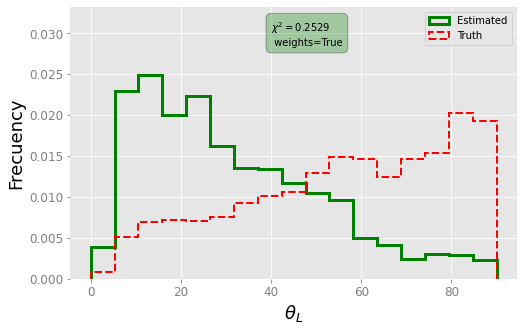

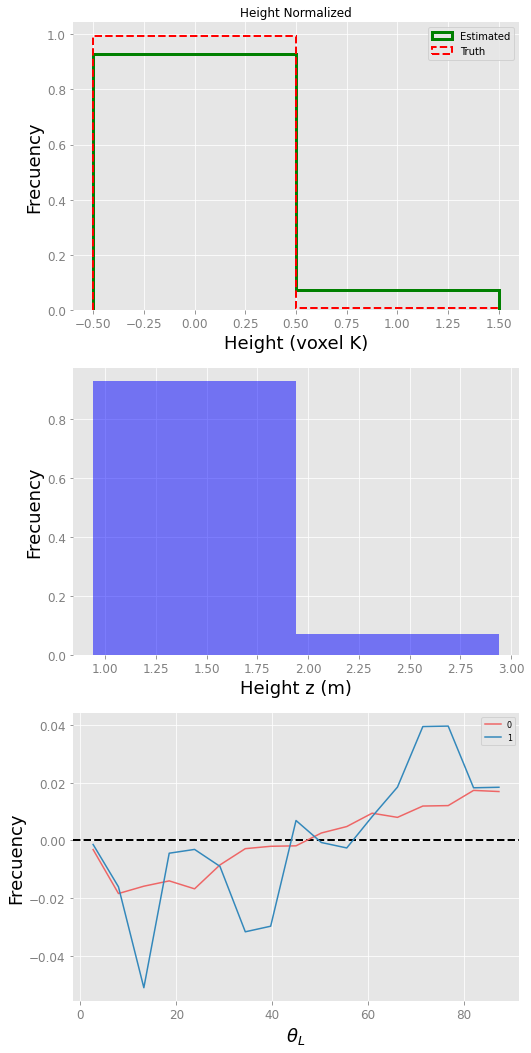

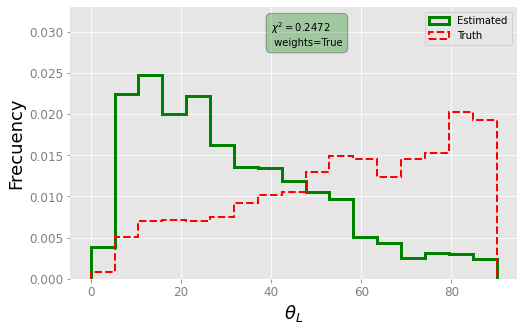

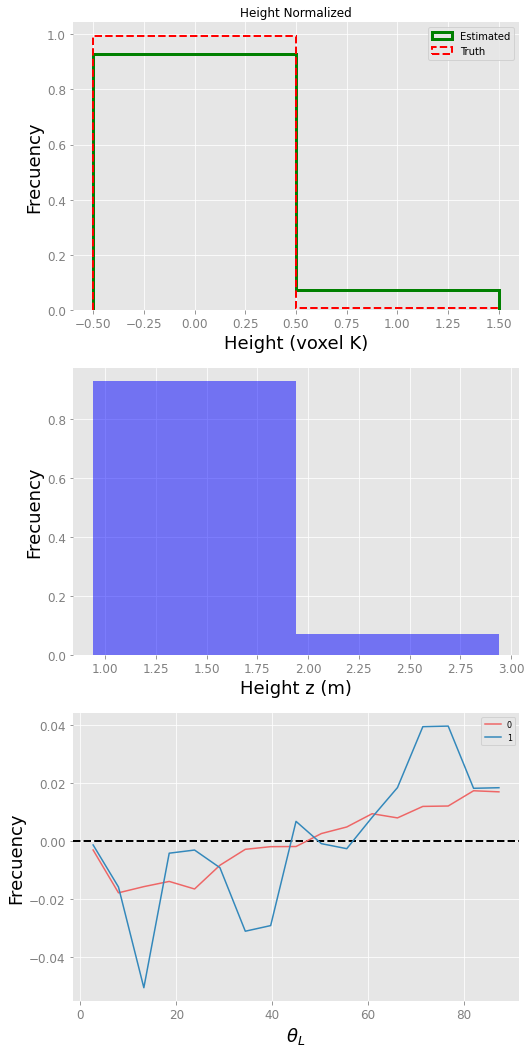

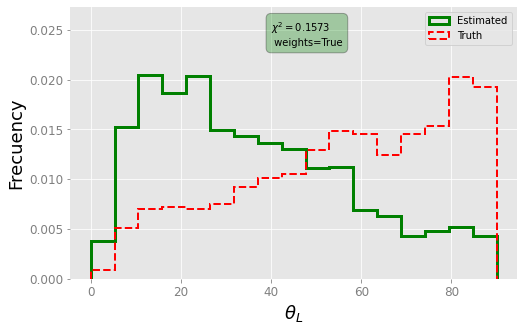

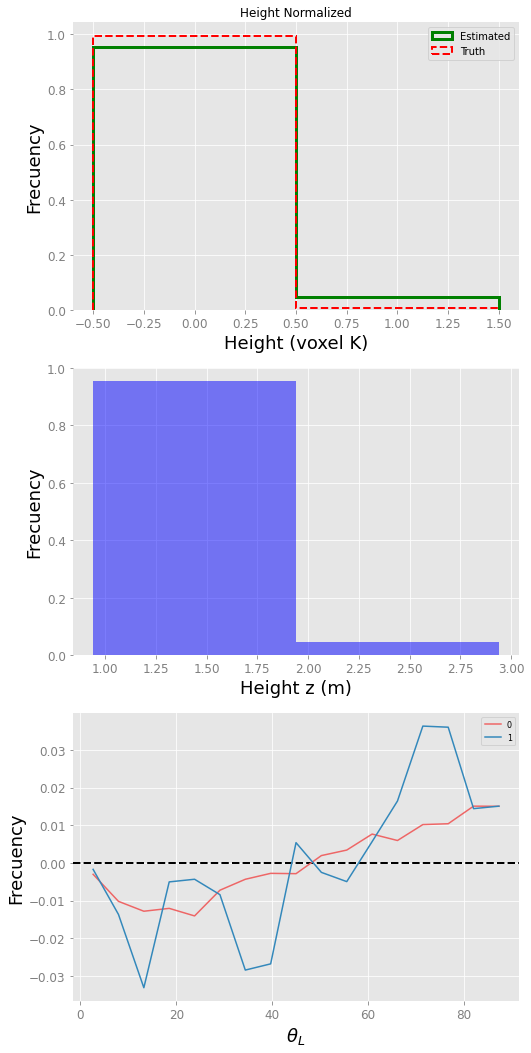

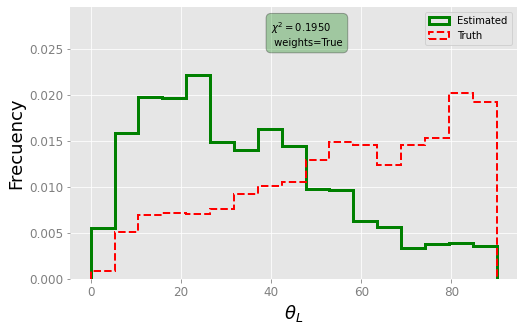

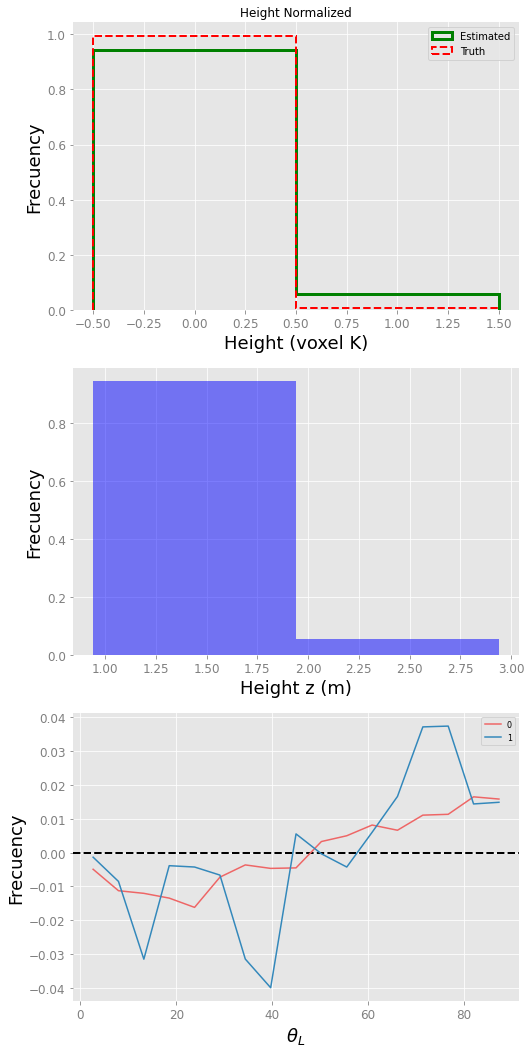

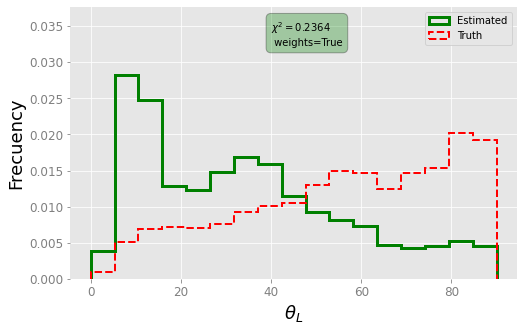

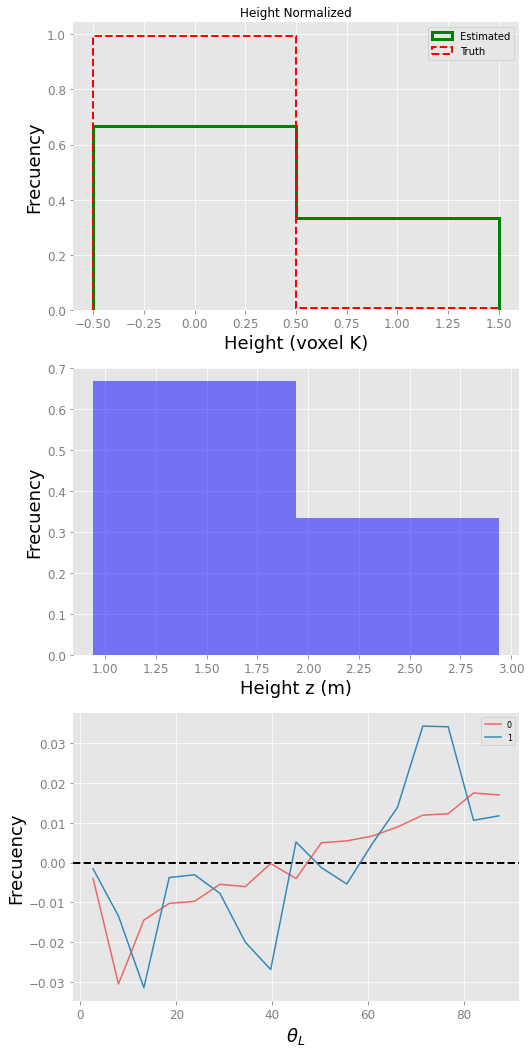

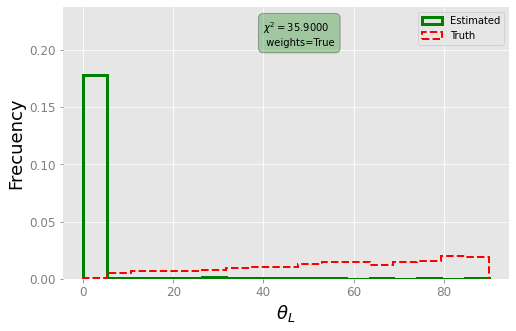

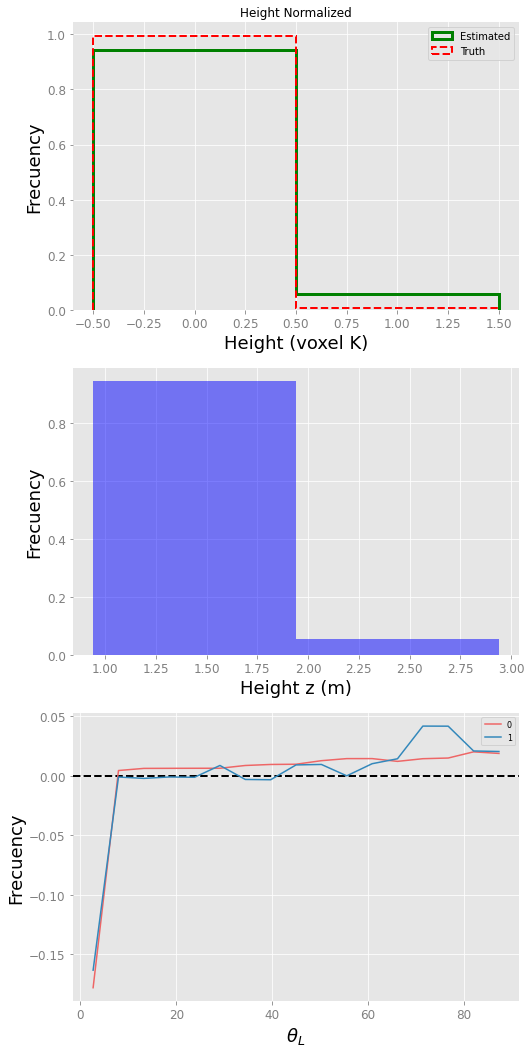

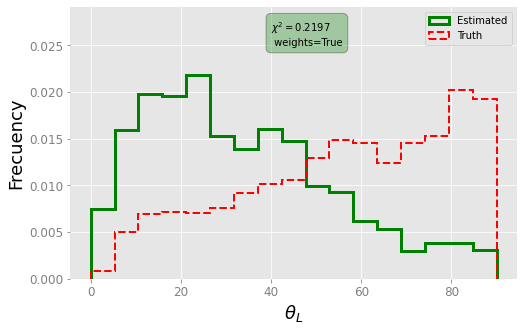

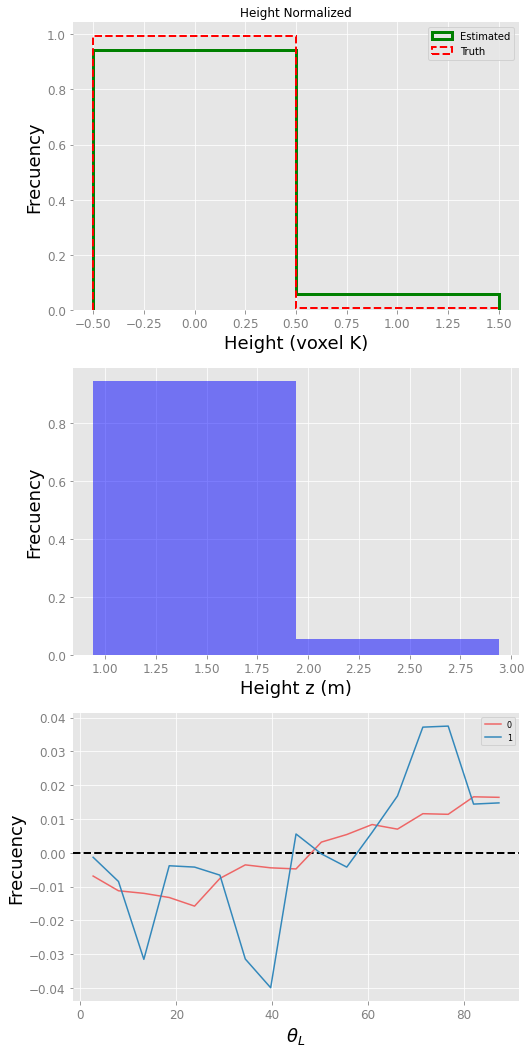

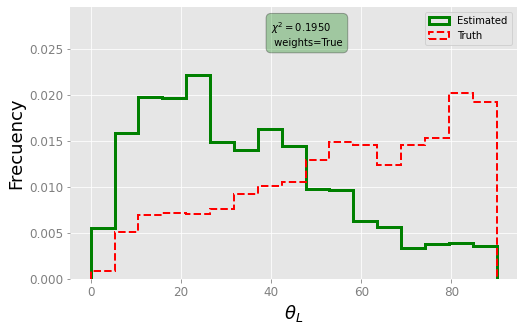

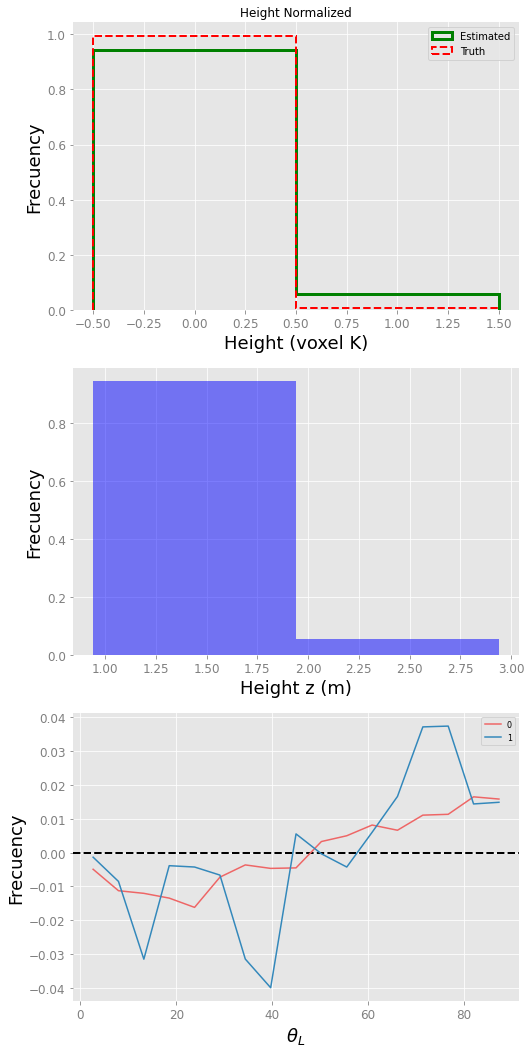

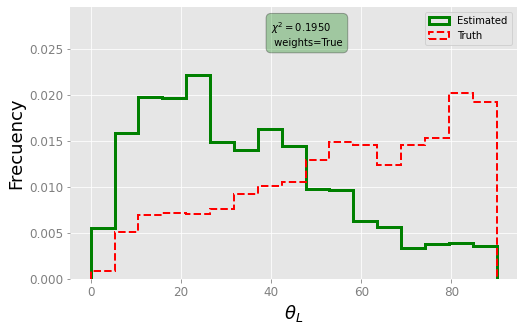

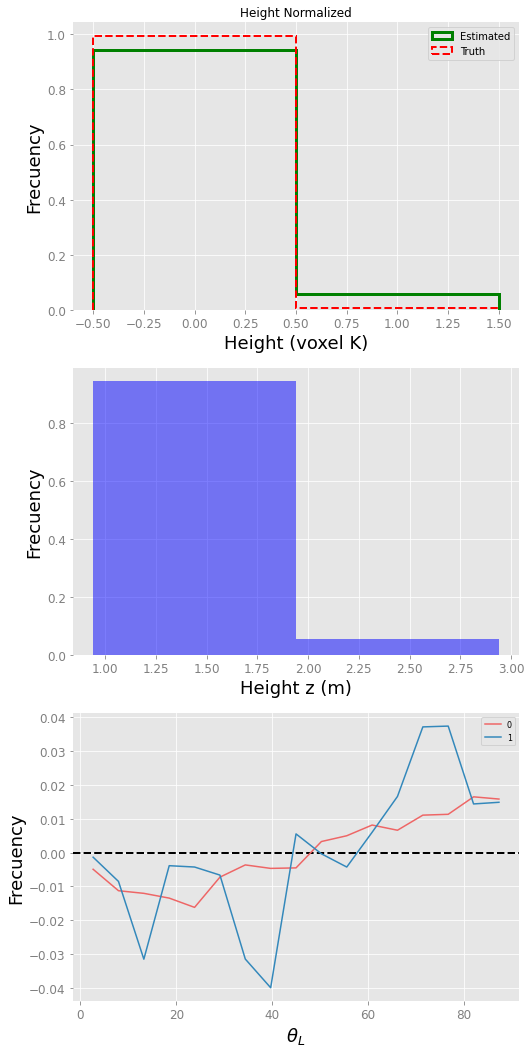

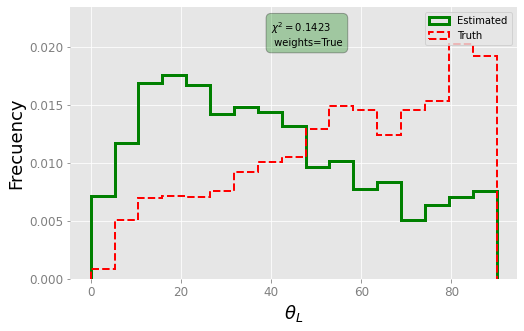

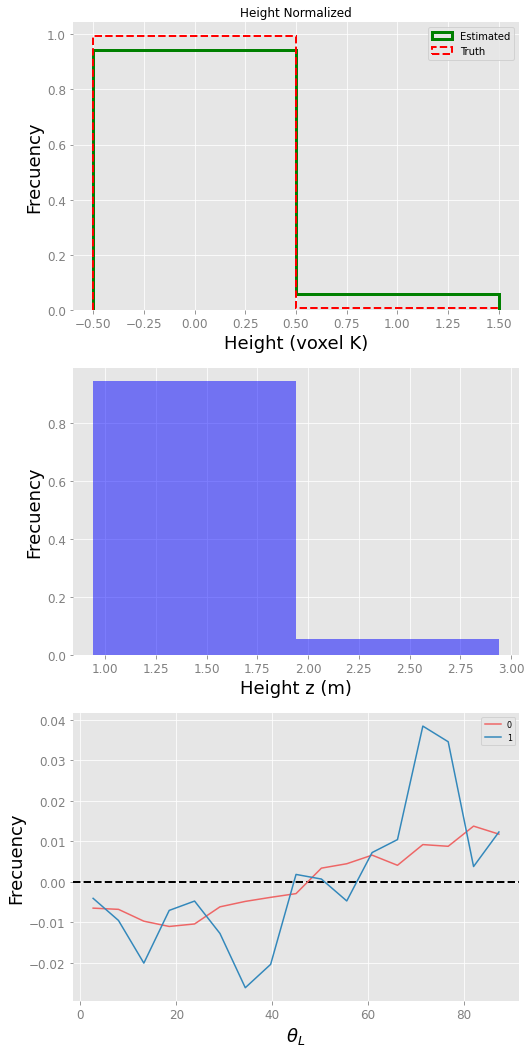

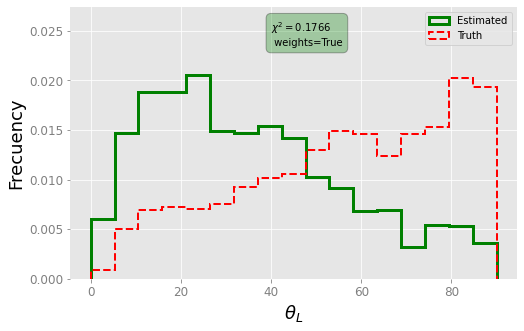

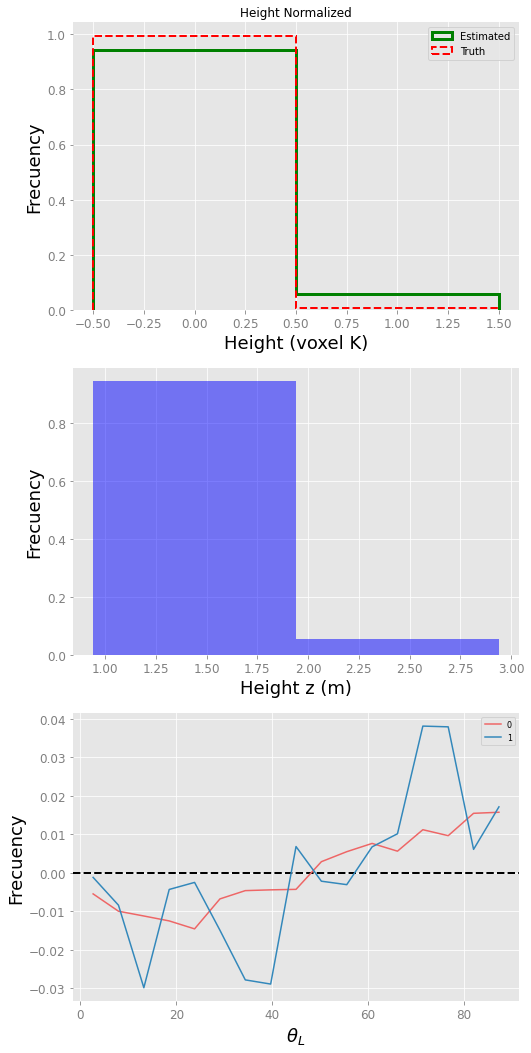

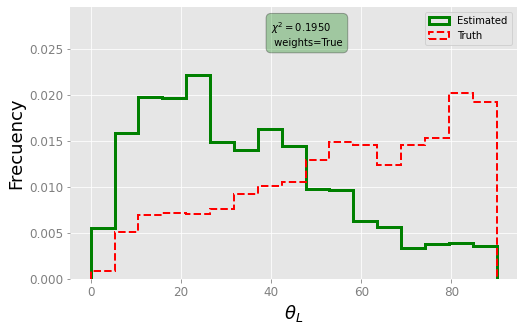

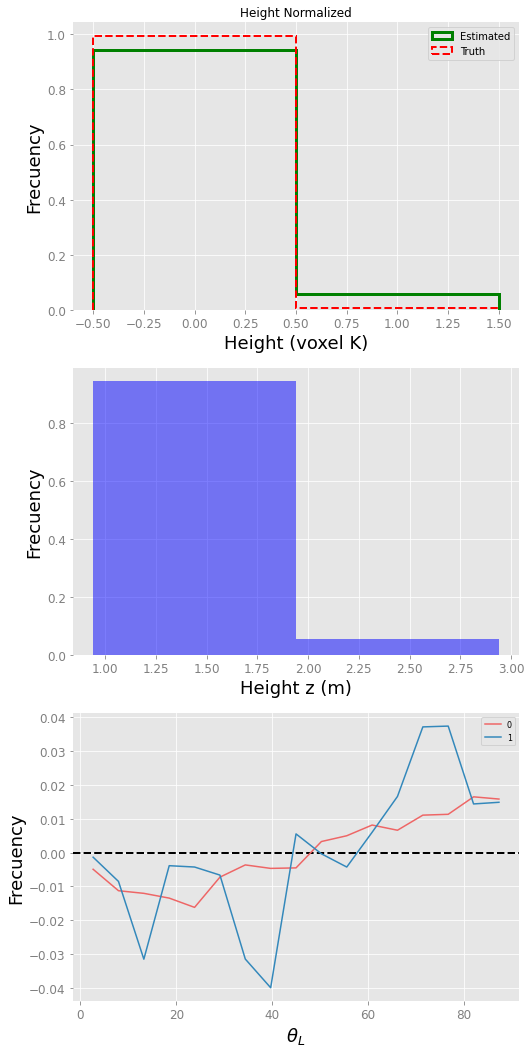

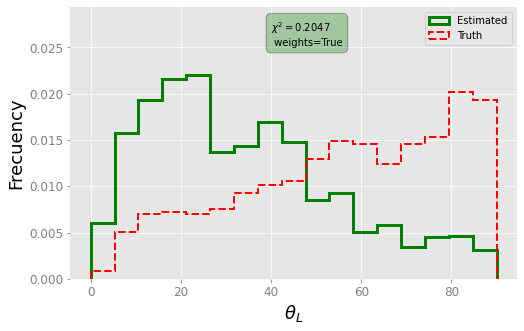

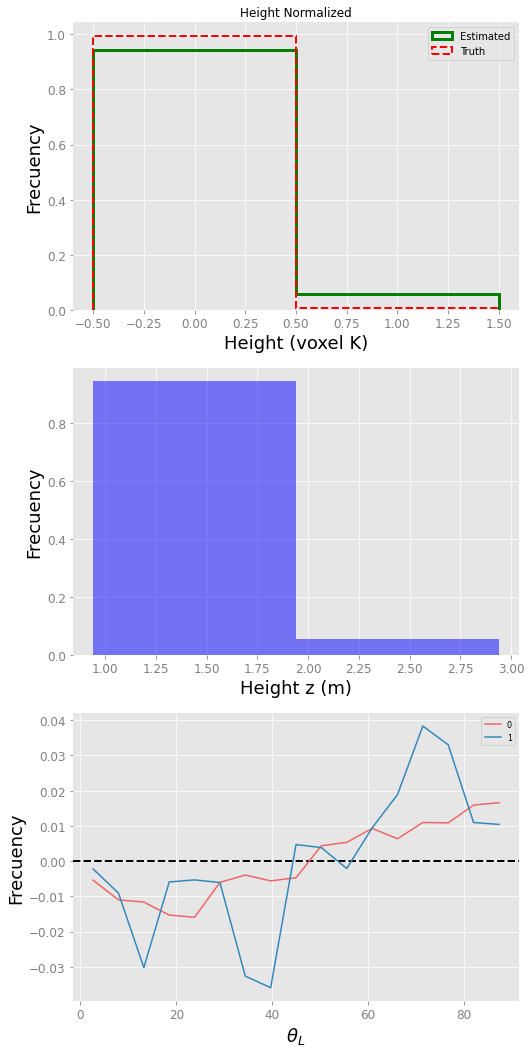

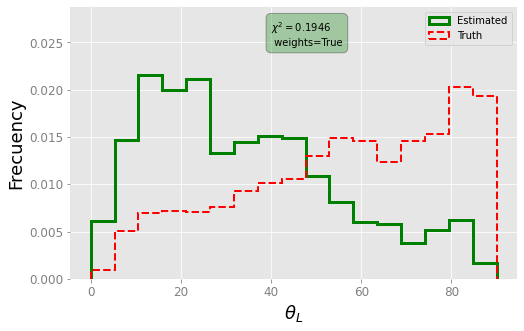

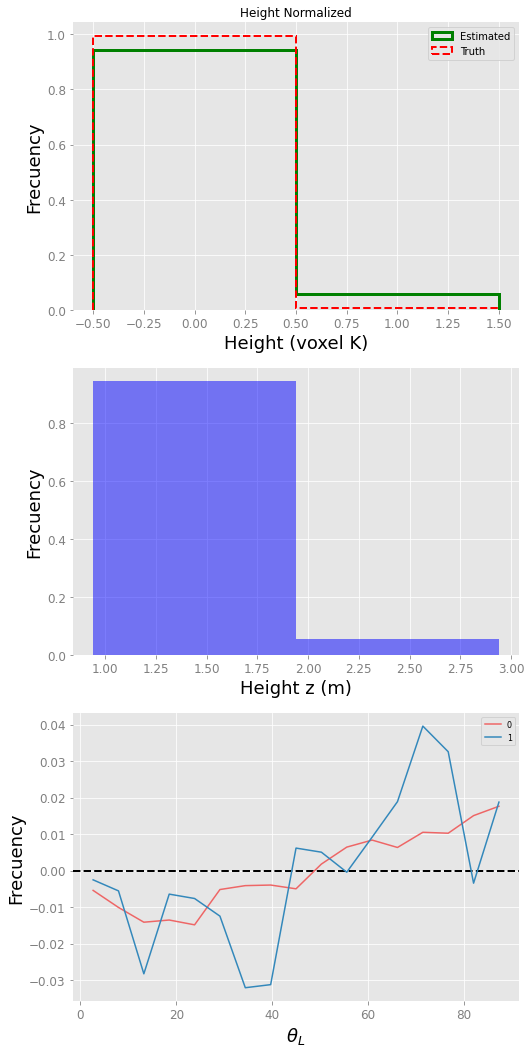

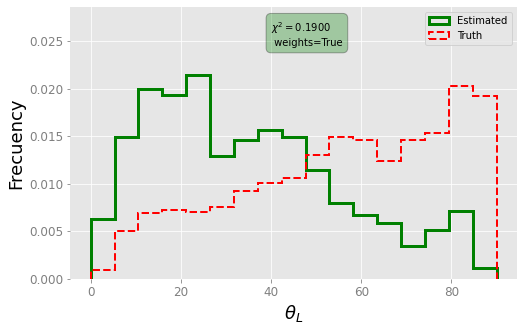

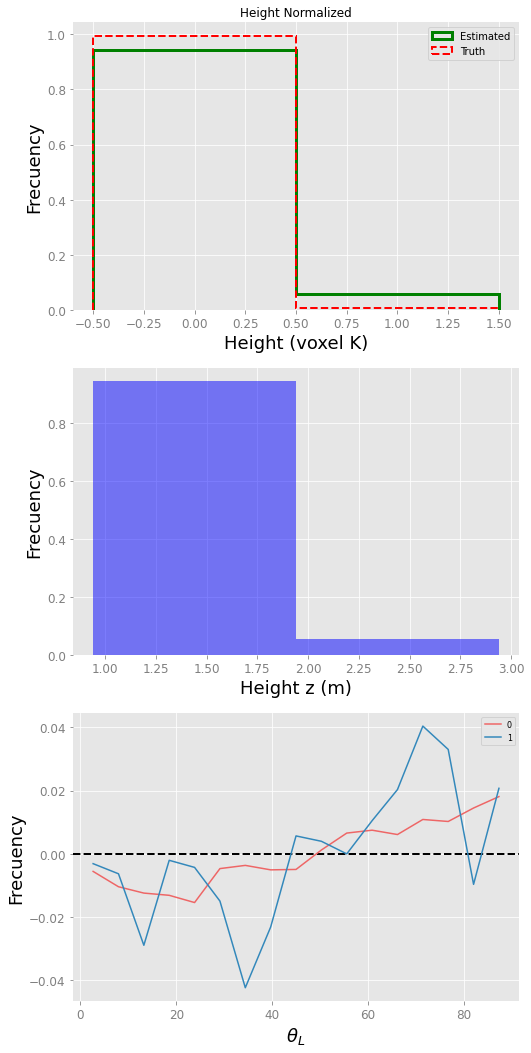

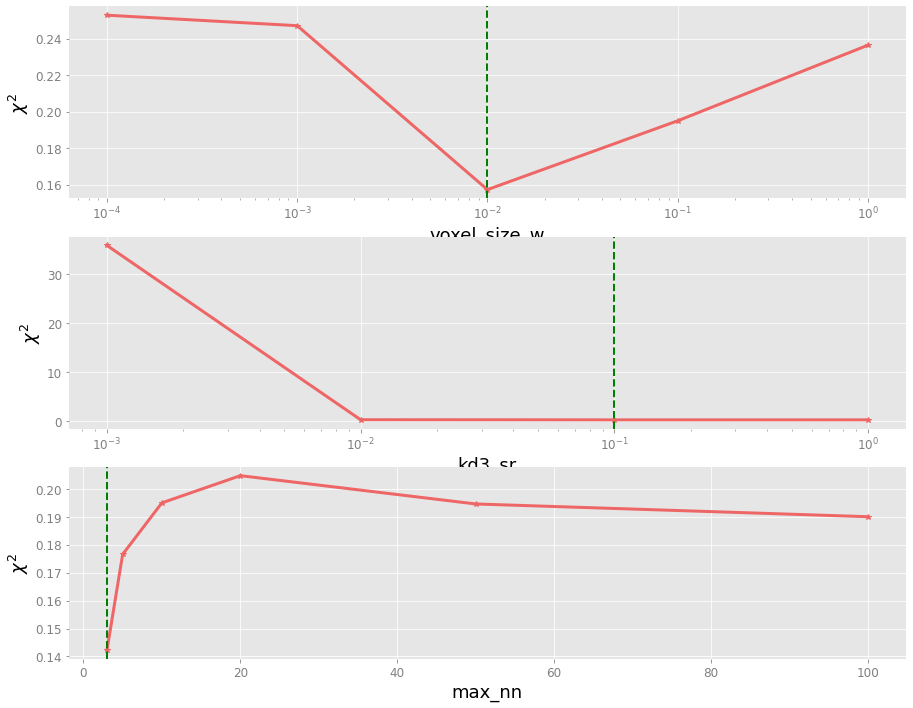

In [25]:
best_fit_lia(mockname, Nleaves)

Number of files: 1
118018 118018
leaf area=0.00 
 voxel_size_w=0.0100 
 kd3_sr=0.1000 
 max_nn=3.0000 


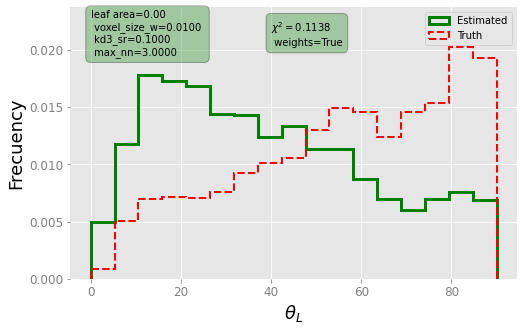

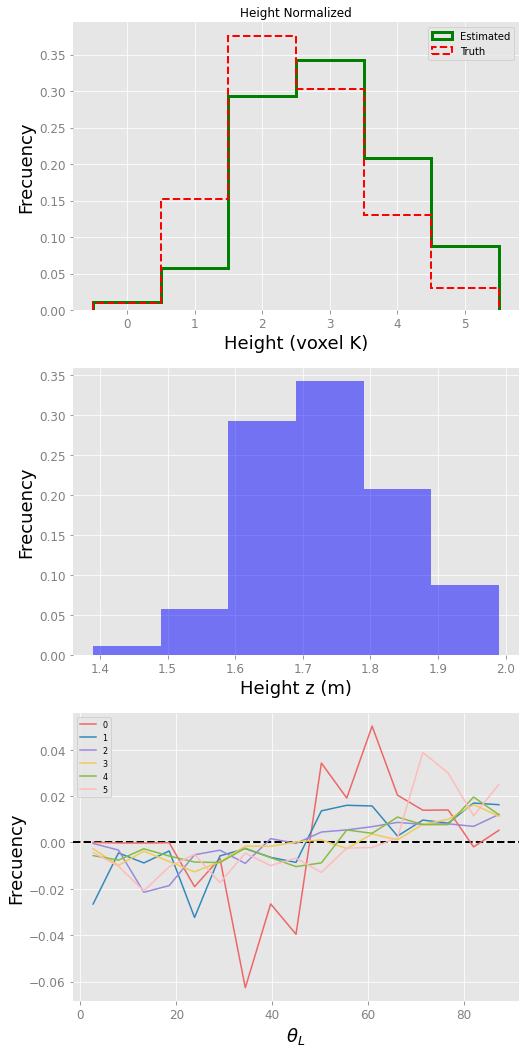

In [32]:
get_lia(mockname)

In [44]:
mydict = dict()

In [48]:
def runall(pointsPR, sensorsPR, inPR, voxel_size, tree, N, PRbounds, resdir, kbins=None, inverted=False):

    inds_file = os.path.join(resdir, 'inds.npy')
    inds0 = np.load(inds_file)
    inds_lia = np.load(os.path.join(_data, mockname, 'lia', 'inds.npy'))

    isfigures = os.path.join(resdir, 'figures')
    if not os.path.exists(isfigures):
        os.makedirs(isfigures)

    attributes2_file = os.path.join(resdir, 'm3s_%s_%s.npy' %(tree, str(voxel_size)))
    if os.path.isfile(attributes2_file):
        m3b = np.load(attributes2_file)

    print('voxel_size:', voxel_size)

    # Load LIAs and its weights saved at `get_lia()`.
    # Size of lias and ws arrays is the original size after leaf and tree extraction only.
    lias, ws = loads.load_lias_ws(mockname, 'tree_0')

    # Create  arrays of original size filled with -99
    lias0 = np.full(N, -99)
    ws0 = np.full(N, -99)

    # fill arrays with lias and ws values where it correspond to.
    lias0[np.where(inds_lia)[0]] = lias
    ws0[np.where(inds_lia)[0]] = ws

    # Finally, apply downsampling and second dowsampling to lias and ws.
    lias = lias0[inds0[inPR]]
    ws = ws0[inds0[inPR]]

    try:
        assert len(lias) == sum(inPR)
    except Exception as e:
        print('lias size does not match with Plant Region size.')
        print(e)

    try:
        assert len(ws) == sum(inPR)
    except Exception as e:
        print('ws size does not match with Plant Region size.')
        print(e)

    voxk = lad.get_voxk(pointsPR, PRbounds, voxel_size)
    bia = lad.get_bia(pointsPR, sensorsPR)
    meshfile = lad.get_meshfile(mockname)

    figext = '%s_%s' %(tree, str(voxel_size))
    
    alphas_k = lad.alpha_k(bia, voxk, lias, ws, resdir, meshfile, figext=figext, 
                            klia=False, use_true_lia=True)

    kmax = m3b.shape[2]
    
    if kbins is None:
        kbins = int(kmax/15)
    print('kmax', kmax)
    print('kbins', kbins)

    oldlad = True
    
    lads_mid_1, clai_1 = lad.get_LADS2(pointsPR, kmax, voxel_size, kbins, alphas_k[:,6], PRbounds, tree, resdir, oldlad=oldlad, C=1)
    lads_0, clai_0 = lad.get_LADS2(pointsPR, kmax, voxel_size, kbins, alphas_k[:,6]*0+1, PRbounds, tree, resdir, oldlad=oldlad, C=1)
    lads_mesh = lad.get_LADS_mesh(meshfile, voxel_size, kbins, kmax, PRbounds, inverted)

    lads = {'Truth':lads_mesh, 'Correction Mean C=1':lads_mid_1, 'No Correction C=1':lads_0}
    attributes_file = os.path.join(resdir, 'm3s_%s_%s.npy' %(tree, str(voxel_size)))
    if os.path.isfile(attributes_file):
        RT = 'Y'
    else:
        RT = 'N'
        
    text = {'tree':tree, 'VS':voxel_size, 'RT':RT, 'CLAI 1.0':np.round(clai_1, 3),  'CLAI 1.0 -- NC':np.round(clai_0, 3)}
    txt = []
    for key, val in text.items():
        txt.append('%s=%s \n' %(key, str(val)))
    text = (' ').join(txt)

    savefig = os.path.join(resdir, 'figures','LAD_%s.png' %(figext))
    figures.plot_lads(lads, text, savefig=savefig)
    
    mydict.update(lads)
    print("hi")
    print(type(lads))
    #print(lads)

    #outdir_res_height = os.path.join(resdir, 'figures','LAD_%s.csv'%(figext))
    
    #pd.DataFrame.from_dict(lads).to_csv(outdir_res_height, index=False)



voxel_size: 0.05
kmax 13
kbins 2
/mnt/sda/Github/LiDAR/data/groimp_mock/voxel/lad_0.05/m3count_tree_0_0.05.npy
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 4 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 2 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
/mnt/sda/Github/LiDAR/data/groimp_mock/voxel/lad_0.05/m3count_tree_0_0.05.npy
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 

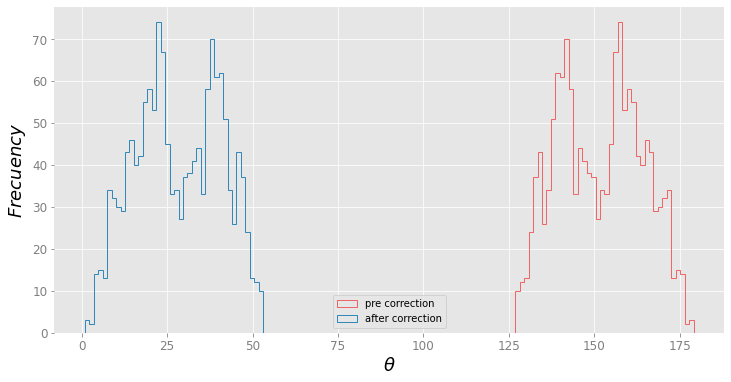

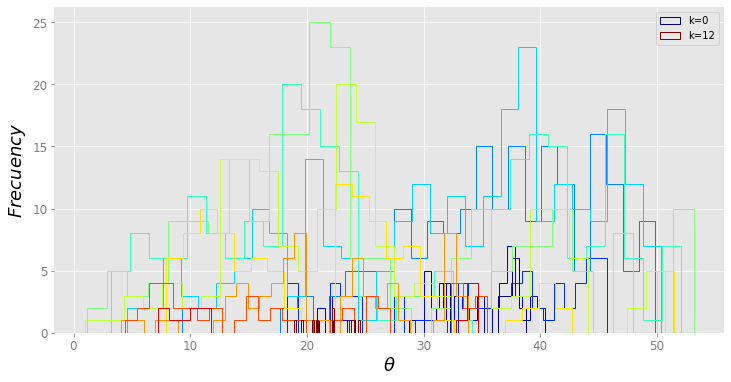

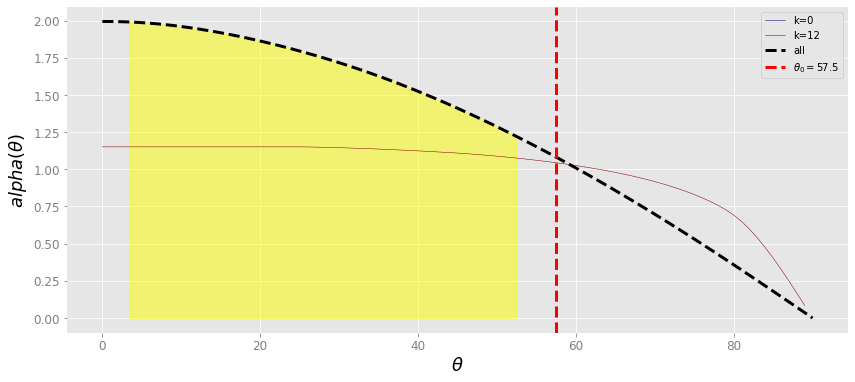

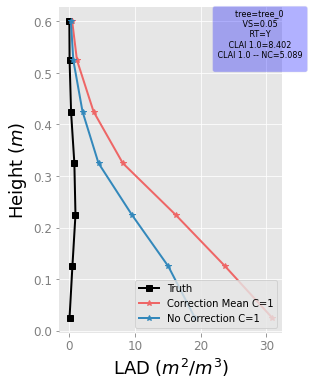

In [49]:

inPR = (leaves) & (trees['tree_0'])
runall(POINTS[inPR], SENSORS[inPR], inPR, voxel_size, 'tree_0', N, (minpointPR, maxpointPR), resdir, kbins=2)

In [50]:
mydict


{'Truth': array([[0.025     , 0.02847086],
        [0.125     , 0.46559084],
        [0.225     , 0.93298512],
        [0.325     , 0.76404918],
        [0.425     , 0.2582217 ],
        [0.525     , 0.03506908],
        [0.6       , 0.        ]]),
 'Correction Mean C=1': array([[2.50000000e-02, 3.09063341e+01],
        [1.25000000e-01, 2.37317316e+01],
        [2.25000000e-01, 1.61779578e+01],
        [3.25000000e-01, 8.14163039e+00],
        [4.25000000e-01, 3.68937227e+00],
        [5.25000000e-01, 1.15733937e+00],
        [6.00000000e-01, 4.33903636e-01]]),
 'No Correction C=1': array([[ 0.025     , 19.13043478],
        [ 0.125     , 15.07130125],
        [ 0.225     ,  9.51889317],
        [ 0.325     ,  4.44073166],
        [ 0.425     ,  2.0072276 ],
        [ 0.525     ,  0.60347007],
        [ 0.6       ,  0.23640662]])}

In [62]:
import csv
import pandas as pd
df = pd.DataFrame.from_dict([mydict])
df


,Truth,Correction Mean C=1,No Correction C=1
0,"[[0.025, 0.028470859019755147], [0.125, 0.4655...","[[0.025, 30.906334126004552], [0.125, 23.73173...","[[0.025, 19.130434782608695], [0.125, 15.07130..."


In [65]:
df["Truth"].str.split(' ',expand=True)

,0
0,NaN


TypeError: argument 1 must have a "write" method